In [5]:
import json
from tqdm import tqdm
import random
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
from sklearn.manifold import TSNE

C:\Users\tara0\Desktop\MPEObservationParser\venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [37]:
class Skipgram(nn.Module):

    def __init__(self, vocab_size, embedding_dim, context_size):
        super(Skipgram, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        # Context size is the number of words before AND after (so * 2)
        self.linear1 = nn.Linear(embedding_dim, 32)
        self.activation_function1 = nn.ReLU()
        
        self.linear2 = nn.Linear(32, vocab_size)
        self.activation_function2 = nn.LogSoftmax(dim = -1)

    def forward(self, inputs):
        # Encode context tokens
        embeds = self.embeddings(inputs)
            
        # Concat each context
        #embeds = torch.cat((embeds))
        model_input = embeds.view(inputs.size(0), -1)
        
        out = self.linear1(model_input)
        out = self.activation_function1(out)
        out = self.linear2(out)
        log_probs = self.activation_function2(out)
        
        return log_probs

# Language Voc

### Pick one

In [7]:
CONTEXT_SIZE = 2
EMBEDDING_DIM = 10
vocabulary = ['<SOS>','Located', 'Object', 'Landmark', 'North', 'South', 'East', 'West', 'Center', 'Not', '<EOS>']
word_to_ix = {word : i for i, word in enumerate(vocabulary)}

print(word_to_ix)

{'<SOS>': 0, 'Located': 1, 'Object': 2, 'Landmark': 3, 'North': 4, 'South': 5, 'East': 6, 'West': 7, 'Center': 8, 'Not': 9, '<EOS>': 10}


In [59]:
CONTEXT_SIZE = 2
EMBEDDING_DIM = 10
vocabulary = ['<SOS>', 'Located', 'Object', 'Landmark', 'I', 'You', 'North', 'South', 'East', 'West', 'Center', 'Not', 'Push', 'Search', '<EOS>']
word_to_ix = {word : i for i, word in enumerate(vocabulary)}

print(word_to_ix)

{'<SOS>': 0, 'Located': 1, 'Object': 2, 'Landmark': 3, 'I': 4, 'You': 5, 'North': 6, 'South': 7, 'East': 8, 'West': 9, 'Center': 10, 'Not': 11, 'Push': 12, 'Search': 13, '<EOS>': 14}


# Load Data

In [8]:
def load():
    # Sentences
    sentences = []
    # Open file
    with open("../data/Sentences_Generated_P1.json", 'r') as f:
        data = json.load(f)
    # Get the sentence of both agent for each step
    for step in range(len(data) -1 ) :
        sentences.append(data["Step " + str(step)]["Agent_0"]["Sentence"])
        sentences.append(data["Step " + str(step)]["Agent_1"]["Sentence"])
    
    """if sentences[0][0] == '<SOS>':
        for sentence in sentences:
            # We delete first and last character
            sentence.pop(0)
            sentence.pop()"""
    return sentences

data = load()

print(data[0])

['<SOS>', 'Located', 'East', 'Landmark', 'South', 'West', '<EOS>']


### Transform the Data

##### Second way

In [58]:
pairs = []

# for each sentence
for sentence in data:
    indices = []
    #print(sentence)
    for word in sentence:
        indices.append(word_to_ix[word])
    
    #print(indices)
    # for each word
    for center_word in range(len(indices)):
        # for each word before/after
        for w in range(-CONTEXT_SIZE, CONTEXT_SIZE + 1):
            context_word = center_word + w
            # Make sure the word existe
            if context_word >= 0 and context_word < len(indices) and center_word != context_word:
                context_word_idx = indices[context_word]
                pairs.append((indices[center_word], context_word_idx))
                #print(indices[center_word], context_word_idx)
del(indices)
#pairs = np.array(pairs) # it will be useful to have this as numpy array

print(data[0])
print(pairs[:3])

['<SOS>', 'Located', 'East', 'Landmark', 'South', 'West', '<EOS>']
[(0, 1), (0, 6), (1, 0)]


## Split the data

In [59]:
# Keep 20% of the data for the training
split = len(pairs)//100*20

train_data = pairs[:split]
test_data = pairs[split:]

print(len(train_data))
print(len(test_data))

319440
1277816


# Model

In [66]:
losses = []
loss_function = nn.NLLLoss()
model = Skipgram(len(vocabulary), EMBEDDING_DIM, CONTEXT_SIZE)
optimizer = optim.SGD(model.parameters(), lr=0.1)
total_loss = 0
nb_epoch = 3000

# Training

In [67]:
# To keep track of the loss
losses = []
losses_test = []

for epoch in tqdm(range(nb_epoch)):
    # Create the batch
    batch = random.sample(train_data,64)

    # Zero out the gradients 
    model.zero_grad()
    
    #Init the loss
    loss = 0
    
    context_batch = []
    target_batch = []
    
    # Get the list of context and target
    for context, target in batch:
        
        context_batch.append(context)
        target_batch.append(target)
        
    # Tranform in into a Tensor
    target_batch = torch.tensor(target_batch, dtype=torch.long)
               
    # Transform the context into a tensor
    context_batch = torch.tensor(context_batch, dtype=torch.long)
    #context_batch.view(4, -1)
    
    """print(context_batch)
    print(target_batch)"""
    
    # Forward pass
    log_probs = model(context_batch)
    
    # En moyenne 2.4 quand pas de backward
    loss = loss_function(log_probs, target_batch)
    
    losses.append(loss.item())
    
    loss.backward()
    
    optimizer.step()
    
    # Every 10000
    if epoch % 100 == 0:
        with torch.no_grad():
            context_batch_test = []
            target_batch_test = []
            # Create the batch
            batch_test = random.sample(test_data,64)

            # Get the list of context and target
            for context, target in batch_test:
                context_batch_test.append(context)
                # Get the id of the target word
                target_batch_test.append(target)

            # Tranform in into a Tensor
            target_batch_test = torch.tensor(target_batch_test, dtype=torch.long)

            # Transform the context into a tensor
            context_batch_test = torch.tensor(context_batch_test, dtype=torch.long)

            # Forward pass
            log_probs_test = model(context_batch_test)

            # En moyenne 2.3 quand pas de backward
            loss_test = loss_function(log_probs_test, target_batch_test)

            losses_test.append(loss_test)


100%|████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:01<00:00, 1513.65it/s]


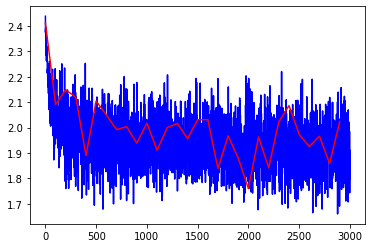

In [68]:
# Representation with matplotlib
y = np.array(losses)
plt.plot(y, color='blue')
test = np.array(losses_test)
plt.plot(np.arange(nb_epoch//100) * 100, test, color='red')
plt.show()

# Representation of the embedding

### Using TSNE

In [69]:
embeddings = model.embeddings.weight.cpu().detach().numpy()
data_frame = pd.DataFrame(embeddings)
tsne = TSNE(n_components=2,perplexity=2,
            learning_rate="auto")

embed_df = tsne.fit_transform(data_frame.values)
embed_df = pd.DataFrame(embed_df, columns=list('XY'))
embed_df["Words"] = vocabulary


# Create the fig
fig = px.scatter(embed_df, x='X', y='Y', text='Words', log_x = False, size_max = 60)

fig.update_traces(textposition='top center')
# setting up the height and title
fig.update_layout(
    height=600,
    title_text='Word embedding chart'
)
# displaying the figure
fig.write_html("../skipgram_tsne.html")
fig

C:\Users\tara0\Desktop\MPEObservationParser\venv\lib\site-packages\sklearn\manifold\_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.



### Using PCA

In [70]:
from sklearn.decomposition import PCA

embeddings = model.embeddings.weight.cpu().detach().numpy()
data_frame = pd.DataFrame(embeddings)
pca = PCA(n_components=2)
embed_df = pca.fit_transform(data_frame.values)
print(embed_df)

embed_df = pd.DataFrame(embed_df, columns=list('XY'))
embed_df["Words"] = vocabulary

# Create the fig
fig = px.scatter(embed_df, x='X', y='Y', text='Words', log_x = False, size_max = 60)

fig.update_traces(textposition='top center')
# setting up the height and title
fig.update_layout(
    height=600,
    title_text='Word embedding chart'
)



# displaying the figure
fig.write_html("../skipgram_pca.html")
fig

[[-1.3994731  -2.3597288 ]
 [-2.1884525  -0.44137105]
 [ 2.4507182  -1.4126611 ]
 [ 0.10596698 -0.14749946]
 [ 0.46661702  2.2563558 ]
 [-1.0973303   0.11930876]
 [-1.8965067   0.7311465 ]
 [-1.5499846   0.6778487 ]
 [ 0.74932486 -0.8200822 ]
 [ 1.7212969   2.5585518 ]
 [ 2.6378238  -1.1618682 ]]


### Calculate the distance between the words

In [47]:
import math

dist = []

for a in range(len(model.embeddings.weight)):
    dist_point = []
    for b in range(len(model.embeddings.weight)):
        if a != b:
            distance = 0
            for i in range(10):
                distance += (model.embeddings.weight[a][i].item() - model.embeddings.weight[b][i]) \
                    * (model.embeddings.weight[a][i] - model.embeddings.weight[b][i])
            distance = math.sqrt(distance)
            dist_point.append(round(distance,2))
        else :
            dist_point.append(0)
    dist.append(dist_point)
    
for d in dist:
    print(d)


[0, 5.43, 3.67, 1.62, 3.44, 4.18, 4.06, 5.98, 4.25, 4.9, 4.01]
[5.43, 0, 4.29, 4.94, 4.43, 5.0, 4.23, 5.11, 3.8, 7.7, 5.66]
[3.67, 4.29, 0, 3.55, 4.35, 5.2, 3.19, 5.48, 3.7, 5.68, 5.16]
[1.62, 4.94, 3.55, 0, 3.41, 3.55, 4.29, 5.55, 4.19, 4.14, 4.6]
[3.44, 4.43, 4.35, 3.41, 0, 4.48, 3.62, 4.49, 4.98, 5.46, 3.81]
[4.18, 5.0, 5.2, 3.55, 4.48, 0, 4.25, 5.51, 4.47, 6.39, 4.6]
[4.06, 4.23, 3.19, 4.29, 3.62, 4.25, 0, 4.55, 3.81, 6.49, 3.19]
[5.98, 5.11, 5.48, 5.55, 4.49, 5.51, 4.55, 0, 5.27, 6.04, 4.17]
[4.25, 3.8, 3.7, 4.19, 4.98, 4.47, 3.81, 5.27, 0, 7.01, 4.89]
[4.9, 7.7, 5.68, 4.14, 5.46, 6.39, 6.49, 6.04, 7.01, 0, 6.18]
[4.01, 5.66, 5.16, 4.6, 3.81, 4.6, 3.19, 4.17, 4.89, 6.18, 0]


In [67]:
#TESTING
contexte = [(['Located', 'South', 'North', 'East'], 'Object')]

context_batch = []
target_batch = []

# Get the list of context and target
for context, target in contexte:
    context_batch.append(context)
    # Get the id of the target word
    target_batch.append(word_to_ix[target])

# Tranform in into a Tensor
target_batch = torch.tensor(target_batch, dtype=torch.long)

# Adapt the shape of the context
context_idxs = []
for w in context_batch:
    context_id = []
    for word in w:
        context_id.append(word_to_ix[word])
    context_idxs.append(context_id)

# Transform the context into a tensor
context_idxs = torch.tensor(context_idxs, dtype=torch.long)

# Forward pass
log_probs = model(context_idxs)

print(log_probs)
    
#Print result
print(f'Context: {contexte}\n')
print(f'Prediction: {torch.argmax(log_probs[0]).item()}')

tensor([[-12.7288, -12.4049,  -1.1460,  -1.3041, -10.8908,  -0.8933, -13.9558,
         -13.5910,  -7.5480,  -7.6331, -12.4099,  -8.9979, -11.0384,  -8.6024,
         -11.3455]], grad_fn=<LogSoftmaxBackward0>)
Context: [(['Located', 'South', 'North', 'East'], 'Object')]

Prediction: 5
